In [1]:
import gymnasium as gym
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import List, Tuple
from collections import deque

In [2]:
class Config:
    """
    Class containing hyperparameters and configuration settings for the agent.
    """
    learning_rate = 0.001         # Learning rate (alpha)
    discount_factor = 0.9         # Discount rate (gamma)    
    sync_interval  = 10          # Number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # Size of replay memory
    mini_batch_size = 32            # Size of the training dataset sampled from the replay memory


In [3]:
class DeepQLearningNetwork(nn.Module):
    def __init__(self, in_states, hidden_size, actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, hidden_size)
        self.out = nn.Linear(hidden_size, actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [4]:
class ReplayMemory:
    '''Replay memory to store transitions.'''
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        '''Used to handle (state, action, reward, next_state, done) transitions.'''
        self.memory.append(transition)

    def sample(self, sample_size):
        '''Sample a random batch of transitions.'''
        return random.sample(self.memory, sample_size)

    def __len__(self):
        '''Return the current size of the memory.'''
        return len(self.memory)

In [5]:
class FrozenLakeDQL:
    ACTIONS = ['L', 'D', 'R', 'U']

    def __init__(self, config: Config):
        """
        Initializes the FrozenLakeDQL agent.

        Args:
            config (Config): Configuration object containing hyperparameters.
        """
        self.config = config
        self.criterion = nn.MSELoss()
        self.optimizer = None

    def train(self, episodes: int, render: bool = False, is_slippery: bool = False):
        """
        Trains the Deep Q-Learning model.

        Args:
            episodes (int): Number of episodes to train the model.
            render (bool, optional): Whether to render the environment. Defaults to False.
            is_slippery (bool, optional): Whether the environment is slippery. Defaults to False.
        """
        # Initialize Gym environment
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        epsilon = 1
        memory = ReplayMemory(self.config.replay_memory_size)
        
        # Create policy and target Deep Q-Learning networks
        policy_dqn = DeepQLearningNetwork(in_states=num_states, hidden_size=num_states, actions=num_actions)
        target_dqn = DeepQLearningNetwork(in_states=num_states, hidden_size=num_states, actions=num_actions)
        
        # Sync target and policy networks
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        # Initialize optimizer
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.config.learning_rate)
        
        # Initialize arrays to store rewards and epsilon history
        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
            
        for i in range(episodes):
            state = env.reset()[0] # Initialize to state 0
            terminated = False # True when agent falls in hole or reached goal
            truncated = False # True when agent takes more than 200 actions    

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while not terminated and not truncated:
                # Epsilon-greedy policy
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Take action and observe new state and reward
                new_state, reward, terminated, truncated, _ = env.step(action)
                
                # Store experience in replay memory
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1

            # Update epsilon
            if reward == 1:
                rewards_per_episode[i] = 1
            if len(memory) > self.config.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.config.mini_batch_size)
                self.optimize_model(mini_batch, policy_dqn, target_dqn)        
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Sync target and policy networks
                if step_count > self.config.sync_interval:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()
        
        # Save policy network
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")
        
        # Plot training results
        self.plot_results(rewards_per_episode, epsilon_history)

    def optimize_model(self, mini_batch: List[Tuple[int, int, int, int, bool]], policy_dqn: DeepQLearningNetwork, target_dqn: DeepQLearningNetwork):
        """
        Updates the model based on a mini-batch of experiences.

        Args:
            mini_batch (list): Mini-batch of experiences.
            policy_dqn (DeepQLearningNetwork): Policy network.
            target_dqn (DeepQLearningNetwork): Target network.
        """
        num_states = policy_dqn.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.config.discount_factor * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            target_q[action] = target
            target_q_list.append(target_q)
                
        loss = self.criterion(torch.stack(current_q_list), torch.stack(target_q_list))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state: int, num_states: int) -> torch.Tensor:
        """
        Converts a state into a tensor representation.

        Args:
            state (int): The state to be converted.
            num_states (int): Total number of states.

        Returns:
            torch.Tensor: Tensor representation of the state.
        """
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    def test(self, episodes: int, is_slippery: bool = False):
        """
        Tests the trained model on the environment.

        Args:
            episodes (int): Number of episodes to test the model.
            is_slippery (bool, optional): Whether the environment is slippery. Defaults to False.
        """
        # Initialize Gym environment
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        # Load trained policy network
        policy_dqn = DeepQLearningNetwork(in_states=num_states, hidden_size=num_states, actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()

        # Test the model
        for _ in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False

            while not terminated and not truncated:
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

    def plot_results(self, rewards_per_episode: np.ndarray, epsilon_history: List[float]):
        """
        Plots the results of training.

        Args:
            rewards_per_episode (numpy.ndarray): Array containing rewards per episode.
            epsilon_history (list): List containing epsilon values over episodes
        """
        plt.figure(figsize=(10, 5))

        # Plot average rewards per episode
        sum_rewards = np.zeros(len(rewards_per_episode))
        for i in range(len(rewards_per_episode)):
            sum_rewards[i] = np.sum(rewards_per_episode[max(0, i-100):(i+1)])
        plt.subplot(1, 2, 1)
        plt.plot(sum_rewards)
        plt.title('Average Rewards per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Sum of Rewards (Smoothed)')

        # Plot epsilon decay
        plt.subplot(1, 2, 2)
        plt.plot(epsilon_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        
        plt.tight_layout()
        plt.show()


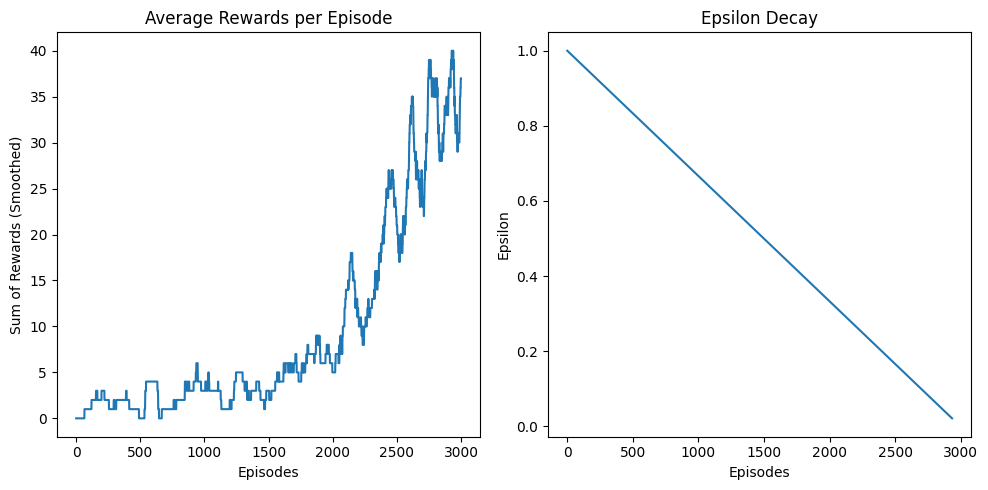

In [6]:
frozen_lake = FrozenLakeDQL(Config())
is_slippery = True
frozen_lake.train(3000, is_slippery=is_slippery)
frozen_lake.test(10, is_slippery=is_slippery)